## 1 데이터 로드 및 데이터 파악

In [1]:
# 데이터 로드
import os
DATA_ROOT = "/home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
print(os.listdir(DATA_ROOT))

# COCO JSON 구조 분석
import json, os, math
from collections import Counter, defaultdict

import numpy as np
import pandas as pd

ann_path = DATA_ROOT + "/COCO_motorcycle (pixel).json"

with open(ann_path, "r") as f:
    coco_data = json.load(f)

print("keys:", coco_data.keys())

['images', 'COCO_motorcycle (pixel).json']
keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [2]:
# ===============================
# COCO Dataset EDA (통합 셀)
# ===============================

import json
import pandas as pd

# ---- COCO JSON 로드 ----
with open(ann_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)

print("===== COCO STRUCTURE =====")
print("keys:", coco_data.keys())

# ---- 카테고리 매핑 ----
cat_id_to_name = {c["id"]: c["name"] for c in coco_data["categories"]}
cat_name_to_id = {c["name"]: c["id"] for c in coco_data["categories"]}


# ==========================================================
# 1) INFO
# ==========================================================
print("\n===== DATASET INFO =====")

info = coco_data.get("info", {})
display(pd.DataFrame([info]))


# ==========================================================
# 2) LICENSES
# ==========================================================
print("\n===== LICENSES =====")

licenses = coco_data.get("licenses", [])
print("num_licenses:", len(licenses))
display(pd.DataFrame(licenses))


# ==========================================================
# 3) IMAGES 분석
# ==========================================================
print("\n===== IMAGES ANALYSIS =====")

images = coco_data["images"]
print("num_images:", len(images))

img_df = pd.DataFrame(images)

print("image columns:", img_df.columns.tolist())
display(img_df.head(3))

# ---- 해상도 통계 ----
if "width" in img_df.columns and "height" in img_df.columns:
    
    print("\n[Resolution stats]")
    print("width  min/mean/median/max:",
          int(img_df["width"].min()),
          round(img_df["width"].mean(), 2),
          img_df["width"].median(),
          int(img_df["width"].max()))

    print("height min/mean/median/max:",
          int(img_df["height"].min()),
          round(img_df["height"].mean(), 2),
          img_df["height"].median(),
          int(img_df["height"].max()))

    res_counts = (
        img_df.groupby(["width", "height"])
        .size()
        .sort_values(ascending=False)
        .head(5)
    )

    print("\nTop resolutions:")
    display(res_counts)


# ---- 파일명 패턴 ----
if "file_name" in img_df.columns:

    print("\n[file_name examples]")
    display(img_df["file_name"].head(10))

    has_subdir = img_df["file_name"].str.contains("/").mean()
    print(f"file_name에 하위 폴더 포함 비율: {has_subdir*100:.1f}%")


# ==========================================================
# 4) CATEGORIES 분석
# ==========================================================
print("\n===== CATEGORY ANALYSIS =====")

cat_df = pd.DataFrame(coco_data["categories"]).sort_values("id")
display(cat_df)

print("\n[Category list]")
for c in coco_data["categories"]:
    print(f"{c['id']} : {c['name']}")

===== COCO STRUCTURE =====
keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

===== DATASET INFO =====


,description,url,version,year,contributor,date_created
0,This is dataset.,https://superannotate.ai,1.0,2022,Superannotate AI,15/09/2022



===== LICENSES =====
num_licenses: 1


,url,id,name
0,https://superannotate.ai,1,Superannotate AI



===== IMAGES ANALYSIS =====
num_images: 200
image columns: ['id', 'file_name', 'height', 'width', 'license']


,id,file_name,height,width,license
0,1,night ride (8).png,1080,1920,1
1,2,night ride (14).png,1080,1920,1
2,3,night ride (11).png,1080,1920,1



[Resolution stats]
width  min/mean/median/max: 1920 1920.0 1920.0 1920
height min/mean/median/max: 1080 1080.0 1080.0 1080

Top resolutions:


width  height
1920   1080      200
dtype: int64


[file_name examples]


0     night ride (8).png
1    night ride (14).png
2    night ride (11).png
3    night ride (24).png
4    night ride (23).png
5    night ride (10).png
6     night ride (9).png
7    night ride (20).png
8    night ride (12).png
9    night ride (17).png
Name: file_name, dtype: object

file_name에 하위 폴더 포함 비율: 0.0%

===== CATEGORY ANALYSIS =====


,id,name,supercategory,isthing,color
5,1323880,Undrivable,Undrivable,1,"[104, 51, 20]"
4,1323881,Road,Road,1,"[105, 51, 20]"
3,1323882,Lane Mark,Lane Mark,1,"[106, 51, 20]"
2,1323884,Moveable,Moveable,1,"[108, 51, 20]"
1,1323885,My bike,My bike,1,"[109, 51, 20]"
0,1329681,Rider,Rider,1,"[17, 74, 20]"



[Category list]
1329681 : Rider
1323885 : My bike
1323884 : Moveable
1323882 : Lane Mark
1323881 : Road
1323880 : Undrivable


In [3]:
# ===============================
# 5) ANNOTATIONS EDA 
# ===============================

import numpy as np
import pandas as pd

annotations = coco_data["annotations"]
print("\n===== ANNOTATIONS ANALYSIS =====")
print("num_annotations:", len(annotations))

ann_df = pd.DataFrame(annotations)
print("annotation columns:", ann_df.columns.tolist())
display(ann_df.head(3))


# ==========================================================
# 5-2) 클래스별 annotation 개수 (category_id 기준)
# ==========================================================
print("\n===== PER-CLASS ANNOTATION COUNT =====")

cat_counts = ann_df["category_id"].value_counts()

summary_df = pd.DataFrame({
    "category_id": cat_counts.index.astype(int),
    "category_name": [cat_id_to_name.get(int(cid), "UNKNOWN") for cid in cat_counts.index],
    "ann_count": cat_counts.values.astype(int),
    "ann_ratio(%)": (cat_counts.values / len(ann_df) * 100)
})

display(summary_df)


# ==========================================================
# 5-3) 이미지당 annotation 개수 분포
# ==========================================================
print("\n===== ANNOTATIONS PER IMAGE =====")

ann_per_img = ann_df.groupby("image_id").size()
print("images with annotations:", ann_per_img.shape[0], "/", len(images))
print("anns per image: min/mean/median/max =",
      int(ann_per_img.min()),
      round(float(ann_per_img.mean()), 3),
      float(ann_per_img.median()),
      int(ann_per_img.max()))

display(ann_per_img.describe())


# ==========================================================
# 5-4) area / bbox 통계
# ==========================================================
print("\n===== AREA / BBOX STATS =====")

# ---- area ----
if "area" in ann_df.columns:
    print("\n[Area stats]")
    print("area min/mean/median/max =",
          float(ann_df["area"].min()),
          round(float(ann_df["area"].mean()), 3),
          float(ann_df["area"].median()),
          float(ann_df["area"].max()))

    area_by_cat = (
        ann_df.groupby("category_id")["area"]
        .agg(["count","mean","median","min","max"])
        .reset_index()
    )
    area_by_cat["category_name"] = area_by_cat["category_id"].map(cat_id_to_name)
    area_by_cat = area_by_cat.sort_values("mean")

    print("\n[Area stats by category (sorted by mean)]")
    display(area_by_cat)

else:
    print("⚠️ 'area' column not found in annotations.")


# ---- bbox ----
if "bbox" in ann_df.columns:
    # bbox = [x, y, w, h]
    wh = np.array([
        b[2:4] for b in ann_df["bbox"].values
        if isinstance(b, list) and len(b) >= 4
    ])

    if len(wh) > 0:
        w = wh[:, 0]
        h = wh[:, 1]

        print("\n[BBox width/height stats]")
        print("w min/mean/median/max:",
              float(w.min()), round(float(w.mean()), 3), float(np.median(w)), float(w.max()))
        print("h min/mean/median/max:",
              float(h.min()), round(float(h.mean()), 3), float(np.median(h)), float(h.max()))

        bbox_df = pd.DataFrame({
            "w": w,
            "h": h,
            "bbox_area(w*h)": w*h
        })
        display(bbox_df.describe())

    else:
        print("⚠️ bbox는 존재하지만, 파싱 가능한 bbox 리스트가 없습니다.")
else:
    print("⚠️ 'bbox' column not found in annotations.")


===== ANNOTATIONS ANALYSIS =====
num_annotations: 2305
annotation columns: ['id', 'image_id', 'segmentation', 'iscrowd', 'bbox', 'area', 'category_id']


,id,image_id,segmentation,iscrowd,bbox,area,category_id
0,1,1,"[[0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0,...",0,"[0.0, 0.0, 1920.0, 551.0]",586530,1323880
1,2,1,"[[1383, 932, 1382, 933, 1381, 934, 1380, 934, ...",0,"[0.0, 243.0, 1920.0, 837.0]",819509,1323881
2,3,1,"[[884, 524, 883, 525, 882, 525, 881, 525, 880,...",0,"[0.0, 280.0, 1659.0, 277.0]",17414,1323882



===== PER-CLASS ANNOTATION COUNT =====


,category_id,category_name,ann_count,ann_ratio(%)
0,1323884,Moveable,1298,56.312364
1,1323882,Lane Mark,207,8.980477
2,1323881,Road,200,8.676790
3,1323880,Undrivable,200,8.676790
4,1323885,My bike,200,8.676790
5,1329681,Rider,200,8.676790



===== ANNOTATIONS PER IMAGE =====
images with annotations: 200 / 200
anns per image: min/mean/median/max = 5 11.525 11.0 26


count    200.000000
mean      11.525000
std        4.504534
min        5.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       26.000000
dtype: float64


===== AREA / BBOX STATS =====

[Area stats]
area min/mean/median/max = 5.0 179919.144 14907.0 1515454.0

[Area stats by category (sorted by mean)]


,category_id,count,mean,median,min,max,category_name
3,1323884,1298,15041.065485,1692.0,5,424086,Moveable
2,1323882,207,28824.676329,22196.0,103,170137,Lane Mark
5,1329681,200,167151.545000,181064.5,40709,269838,Rider
4,1323885,200,327562.445000,319764.0,108350,711443,My bike
1,1323881,200,562131.875000,593954.0,146843,1035064,Road
0,1323880,200,889272.210000,893769.5,351188,1515454,Undrivable



[BBox width/height stats]
w min/mean/median/max: 1.0 792.071 259.0 1920.0
h min/mean/median/max: 2.0 293.641 162.0 1080.0


,w,h,bbox_area(w*h)
count,2305.000000,2305.000000,2.305000e+03
mean,792.070716,293.640781,4.353286e+05
std,817.403358,286.571006,5.629247e+05
min,1.000000,2.000000,5.000000e+00
25%,47.000000,42.000000,1.960000e+03
50%,259.000000,162.000000,4.006800e+04
75%,1920.000000,533.000000,8.198400e+05
max,1920.000000,1080.000000,2.073600e+06


In [ ]:
!pip install opencv-python
!pip install pycocotools-windows
!pip install segmentation-models-pytorch
!pip install wandb
!pip install tqdm
!pip install pycocotools

===== FILE MATCH CHECK =====
missing files: 0

===== BASIC COUNTS =====
이미지 수: 200
annotation 수: 2305

===== SAMPLE VISUALIZATION =====
loading annotations into memory...
Done (t=2.05s)
creating index...
index created!


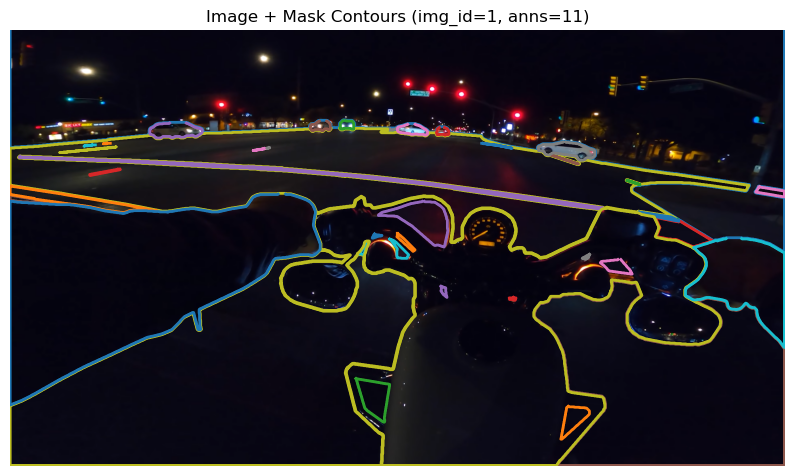

In [10]:
# ===============================
# 6) 파일 매칭 체크 + 샘플 시각화 (통합 셀)
# ===============================

import os, json
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ---- 1) images 폴더와 JSON 매칭 체크 ----
img_dir = os.path.join(DATA_ROOT, "images")

missing = []
for im in images:
    fp = os.path.join(img_dir, im["file_name"])
    if not os.path.exists(fp):
        missing.append(im["file_name"])

print("===== FILE MATCH CHECK =====")
print("missing files:", len(missing))
if len(missing) > 0:
    print("ex) missing sample:", missing[:5])

# ---- 2) 이미지/annotation 수 ----
print("\n===== BASIC COUNTS =====")
print("이미지 수:", len(coco_data["images"]))
print("annotation 수:", len(coco_data["annotations"]))

# ---- 3) 샘플 이미지 + 마스크 윤곽선 시각화 ----
print("\n===== SAMPLE VISUALIZATION =====")

# OpenCV / pycocotools import (없으면 설치 필요)
import cv2
from pycocotools.coco import COCO

coco = COCO(ann_path)

# 첫 샘플 선택
img_id = coco.getImgIds()[0]
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(DATA_ROOT, "images", img_info["file_name"])

# 이미지 읽기
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"cv2.imread failed: {img_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# annotation 가져오기
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

plt.figure(figsize=(10, 8))
plt.imshow(image)
ax = plt.gca()

# 윤곽선 그리기
for ann in anns:
    mask = coco.annToMask(ann).astype(np.uint8)  # (H,W) 0/1

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        cnt = cnt.squeeze()
        if cnt.ndim == 2 and len(cnt) >= 3:
            ax.plot(cnt[:, 0], cnt[:, 1], linewidth=2)

plt.title(f"Image + Mask Contours (img_id={img_id}, anns={len(anns)})")
plt.axis("off")
plt.show()



===== CLASS DISTRIBUTION (Annotation 기준) =====


,category_id,category_name,annotation_count,ratio(%)
0,1323884,Moveable,1298,56.31
1,1323882,Lane Mark,207,8.98
2,1323881,Road,200,8.68
3,1323880,Undrivable,200,8.68
4,1323885,My bike,200,8.68
5,1329681,Rider,200,8.68


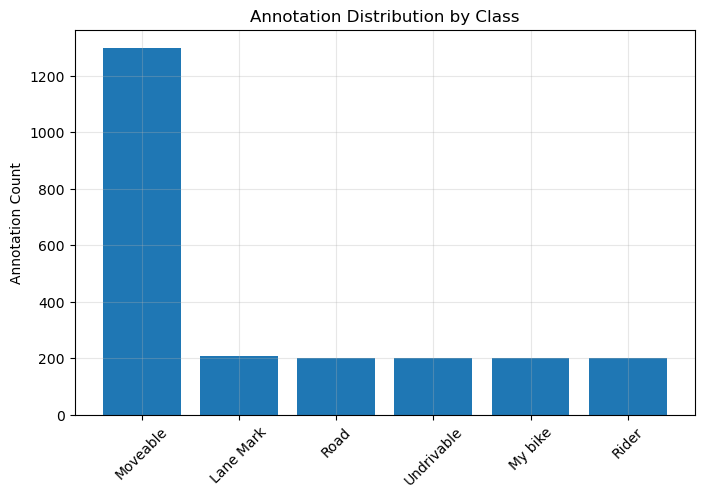

In [14]:
# ===============================
# CLASS DISTRIBUTION + NIGHT BRIGHTNESS ANALYSIS
# ===============================

from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


# ==========================================================
# 1) 클래스 분포 분석 (annotation 기준)
# ==========================================================
print("\n===== CLASS DISTRIBUTION (Annotation 기준) =====")

cls_counter = Counter(ann["category_id"] for ann in coco_data["annotations"])
total = sum(cls_counter.values())

df_cls = (
    pd.DataFrame([
        {
            "category_id": cid,
            "category_name": cat_id_to_name.get(cid, "UNKNOWN"),
            "annotation_count": int(cnt),
            "ratio(%)": round(cnt / total * 100, 2),
        }
        for cid, cnt in cls_counter.items()
    ])
    .sort_values("annotation_count", ascending=False)
    .reset_index(drop=True)
)

display(df_cls)


# ---- 클래스 분포 시각화 ----
plt.figure(figsize=(8,5))
plt.bar(df_cls["category_name"], df_cls["annotation_count"])
plt.title("Annotation Distribution by Class")
plt.ylabel("Annotation Count")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()



===== NIGHT BRIGHTNESS ANALYSIS =====
이미지 수 (Number of Images): 200  (읽기 실패: 0)
평균 픽셀 밝기 (Mean Pixel Intensity): 45.66
중앙값 픽셀 밝기 (Median Pixel Intensity): 33.61
픽셀 밝기 표준편차 (Pixel Intensity Std): 26.01
최소 픽셀 밝기 (Min Pixel Intensity): 10.35
최대 픽셀 밝기 (Max Pixel Intensity): 120.78


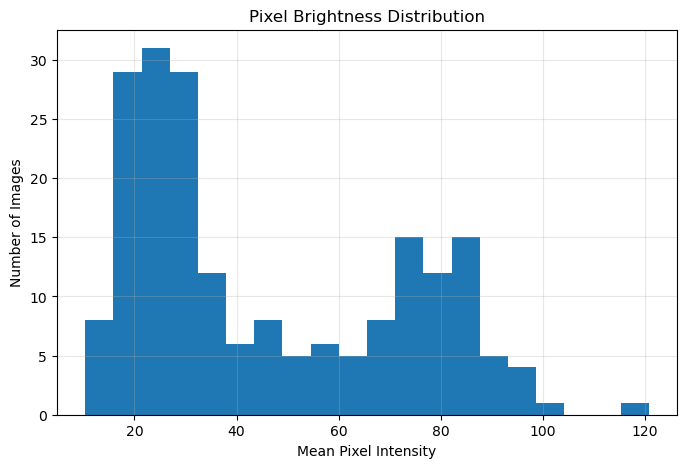

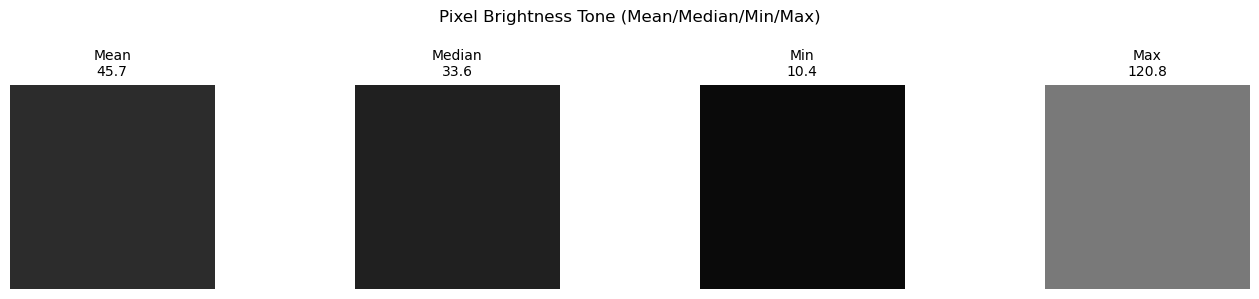

In [13]:

# ----------------------------------------------------------
# 2) 야간 밝기 특성 분석 (Mean Pixel Intensity per Image)
# ----------------------------------------------------------
print("\n===== NIGHT BRIGHTNESS ANALYSIS =====")

brightness = []
bad_files = 0

for img in coco_data["images"]:
    img_path = os.path.join(DATA_ROOT, "images", img["file_name"])
    im = cv2.imread(img_path)
    if im is None:
        bad_files += 1
        continue
    brightness.append(im.mean())

brightness_np = np.array(brightness)

print(f"이미지 수 (Number of Images): {len(brightness_np)}  (읽기 실패: {bad_files})")
print(f"평균 픽셀 밝기 (Mean Pixel Intensity): {brightness_np.mean():.2f}")
print(f"중앙값 픽셀 밝기 (Median Pixel Intensity): {np.median(brightness_np):.2f}")
print(f"픽셀 밝기 표준편차 (Pixel Intensity Std): {brightness_np.std():.2f}")
print(f"최소 픽셀 밝기 (Min Pixel Intensity): {brightness_np.min():.2f}")
print(f"최대 픽셀 밝기 (Max Pixel Intensity): {brightness_np.max():.2f}")

plt.figure(figsize=(8, 5))
plt.hist(brightness_np, bins=20)
plt.title("Pixel Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Number of Images")
plt.grid(alpha=0.3)
plt.show()


# ----------------------------------------------------------
# 3) 밝기 통계(Mean/Median/Min/Max)를 회색 Tone으로 표시
#    (Std는 톤으로 표현해도 직관성이 떨어져서 제외)
# ----------------------------------------------------------
values = [
    brightness_np.mean(),
    np.median(brightness_np),
    brightness_np.min(),
    brightness_np.max()
]
labels = ["Mean", "Median", "Min", "Max"]

plt.figure(figsize=(14, 3))  # 톤 이미지를 좀 더 크게
for i, val in enumerate(values):
    gray = float(val) / 255.0  # 0~1 정규화
    ax = plt.subplot(1, len(values), i + 1)
    ax.imshow([[gray]], cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"{labels[i]}\n{val:.1f}", fontsize=10)
    ax.axis("off")

plt.suptitle("Pixel Brightness Tone (Mean/Median/Min/Max)", fontsize=12)
plt.tight_layout()
plt.show()


## 2. Baseline 선택 (DeepLabV3+ vs U-Net)
### 기준: 동일한 backbone(ResNet 50)을 기준으로 성능이 좋은 모델 선택

### 2.1.1. DeepLab V3

In [16]:
import os, random
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

class COCOSemSeg(Dataset):
    """
    COCO instance/pixel annotations -> semantic mask (H,W) with train ids.
    공정 비교(DeepLabV3+ vs U-Net, backbone=ResNet50)를 위해:
      - 동일한 resize
      - 동일한 normalize(외부 주입 가능)
      - train에만 augmentation
    """
    def __init__(
        self,
        coco,                 # COCO object
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512, 512),
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        hflip_p=0.5,
        priority_order=None,   # 예: [Undrivable, Moveable, ...] 처럼 "위험 우선" 덮어쓰기 순서 지정 가능
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.hflip_p = hflip_p

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        # priority_order가 들어오면 category_id 기준으로 덮어쓰기 우선순위를 정함
        # (기본 None이면 기존처럼 COCO anns 순서대로 덮어쓰기)
        self.priority_order = priority_order
        if self.priority_order is not None:
            # priority_order는 category_id 리스트라고 가정
            self._prio_rank = {cid: i for i, cid in enumerate(self.priority_order)}

    def __len__(self):
        return len(self.img_ids)

    def _build_mask(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint8)

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        # (옵션) 위험 우선순위 덮어쓰기: priority_order 앞쪽/뒤쪽 중 무엇이 우선인지 실험 가능
        if self.priority_order is not None:
            # rank가 작은 것부터 먼저 칠하고, rank 큰 것이 마지막에 덮어쓰도록(=우선)
            anns = sorted(
                anns,
                key=lambda a: self._prio_rank.get(a["category_id"], -1)
            )

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]

        return mask

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size

        mask = self._build_mask(img_id, H, W)
        mask = Image.fromarray(mask)

        # ---- 공정 비교를 위한 동일 resize ----
        img = TF.resize(img, self.size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=Image.NEAREST)

        # ---- train에만 augmentation ----
        if self.train and random.random() < self.hflip_p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [17]:
# ======================
# COCO 이미지 ID 무작위 분할 + SemSeg Dataset/DataLoader
# ======================

import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader

# ======================
# 재현성 설정
# ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ======================
# 이미지 폴더 경로
# ======================
IMG_DIR = os.path.join(DATA_ROOT, "images")

# ======================
# category_id → 학습용 class index 매핑 (background=0, classes=1..K)
# ======================
categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # background 포함

# (옵션) 학습 class index -> name (IoU 출력용)
train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

# ======================
# 이미지 ID 분할 (중요: rng.shuffle로 재현성 고정)
# ======================
all_img_ids = sorted(coco.getImgIds())
rng = random.Random(SEED)
rng.shuffle(all_img_ids)  # ✅ 전역 random.shuffle 대신 rng.shuffle 사용

n = len(all_img_ids)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)

train_ids = all_img_ids[:n_train]
val_ids   = all_img_ids[n_train:n_train + n_val]
test_ids  = all_img_ids[n_train + n_val:]

# ======================
# Dataset 생성
# ======================
train_ds = COCOSemSeg(coco, IMG_DIR, train_ids, id2train, size=(512, 512), train=True)
val_ds   = COCOSemSeg(coco, IMG_DIR, val_ids,   id2train, size=(512, 512), train=False)

# ======================
# DataLoader 생성
# ======================
NUM_WORKERS = 2

# Windows/Jupyter 안정성: persistent_workers 조건부
persistent_ok = (NUM_WORKERS > 0 and os.name != "nt")

train_loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    worker_init_fn=seed_worker,
    generator=g,
    persistent_workers=persistent_ok
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    worker_init_fn=seed_worker,
    generator=g,
    persistent_workers=persistent_ok
)

print("train/val/test:", len(train_ids), len(val_ids), len(test_ids))
print("NUM_CLASSES:", NUM_CLASSES)
print("classes:", [train2name[i] for i in range(1, NUM_CLASSES)])

train/val/test: 160 20 20
NUM_CLASSES: 7
classes: ['Undrivable', 'Road', 'Lane Mark', 'Moveable', 'My bike', 'Rider']


### DeepLab 모델 결정

In [18]:
# =========================================
# 0) train index -> class name (공통)
# =========================================
train2name = {0: "background"}
for cat in categories:
    train_idx = id2train[cat["id"]]
    train2name[train_idx] = cat["name"]


# =========================================
# 1) 공통 유틸: 모델 출력(logits) 통일
#    - torchvision DeepLabV3: dict["out"]
#    - smp(Unet/DeepLabV3Plus): tensor
# =========================================
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out


# =========================================
# 2) 모델 생성 함수 (교체 가능 구조)
#    mode="deeplabv3_torchvision" (현재)
#    mode="unet_smp" / "deeplabv3plus_smp" (나중)
# =========================================
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

def build_model(mode: str, num_classes: int, device: str,
                encoder_name: str = "resnet50", encoder_weights: str = "imagenet"):
    """
    mode:
      - "deeplabv3_torchvision": (ResNet50 backbone만 현실적으로 사용)
      - "unet_smp": EfficientNet/ResNet 등 encoder 자유
      - "deeplabv3plus_smp": EfficientNet/ResNet 등 encoder 자유

    encoder_name/encoder_weights는 smp 계열에서만 사용됨.
    """
    if mode == "deeplabv3_torchvision":
        # torchvision DeepLabV3: backbone=ResNet50 고정(공식 제공)
        model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
        model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        return model.to(device)

    elif mode in ["unet_smp", "deeplabv3plus_smp"]:
        import segmentation_models_pytorch as smp

        if mode == "unet_smp":
            model = smp.Unet(
                encoder_name=encoder_name,        # 예: "efficientnet-b0", "resnet50"
                encoder_weights=encoder_weights,  # "imagenet" or None
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        else:
            model = smp.DeepLabV3Plus(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        return model.to(device)

    else:
        raise ValueError(f"Unknown mode: {mode}")


# =========================================
# 3) Optim/Loss 생성 함수 (공통)
#    - 어떤 모델로 바꿔도 동일하게 사용
# =========================================
def build_optim_and_loss(model, lr=3e-4, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    return criterion, optimizer


# =========================================
# 4) 지금은 DeepLabV3(ResNet50)로 시작
# =========================================
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MODEL_MODE = "deeplabv3_torchvision"  # ✅ 현재 baseline
model = build_model(MODEL_MODE, NUM_CLASSES, device=device)

criterion, optimizer = build_optim_and_loss(model, lr=3e-4, wd=1e-4)

print(f"model ready: {MODEL_MODE}")

device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


model ready: deeplabv3_torchvision


In [19]:
# =========================================
# 0) train index -> class name (공통)
# =========================================
train2name = {0: "background"}
for cat in categories:
    train_idx = id2train[cat["id"]]
    train2name[train_idx] = cat["name"]


# =========================================
# 1) 공통 유틸: 모델 출력(logits) 통일
#    - torchvision DeepLabV3: dict["out"]
#    - smp(Unet/DeepLabV3Plus): tensor
# =========================================
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out


# =========================================
# 2) 모델 생성 함수 (교체 가능 구조)
#    mode="deeplabv3_torchvision" (현재)
#    mode="unet_smp" / "deeplabv3plus_smp" (나중)
# =========================================
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

def build_model(mode: str, num_classes: int, device: str,
                encoder_name: str = "resnet50", encoder_weights: str = "imagenet"):
    """
    mode:
      - "deeplabv3_torchvision": (ResNet50 backbone만 현실적으로 사용)
      - "unet_smp": EfficientNet/ResNet 등 encoder 자유
      - "deeplabv3plus_smp": EfficientNet/ResNet 등 encoder 자유

    encoder_name/encoder_weights는 smp 계열에서만 사용됨.
    """
    if mode == "deeplabv3_torchvision":
        # torchvision DeepLabV3: backbone=ResNet50 고정(공식 제공)
        model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
        model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        return model.to(device)

    elif mode in ["unet_smp", "deeplabv3plus_smp"]:
        import segmentation_models_pytorch as smp

        if mode == "unet_smp":
            model = smp.Unet(
                encoder_name=encoder_name,        # 예: "efficientnet-b0", "resnet50"
                encoder_weights=encoder_weights,  # "imagenet" or None
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        else:
            model = smp.DeepLabV3Plus(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        return model.to(device)

    else:
        raise ValueError(f"Unknown mode: {mode}")


# =========================================
# 3) Optim/Loss 생성 함수 (공통)
#    - 어떤 모델로 바꿔도 동일하게 사용
# =========================================
def build_optim_and_loss(model, lr=3e-4, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    return criterion, optimizer


# =========================================
# 4) 지금은 DeepLabV3(ResNet50)로 시작
# =========================================
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MODEL_MODE = "deeplabv3_torchvision"  # ✅ 현재 baseline
model = build_model(MODEL_MODE, NUM_CLASSES, device=device)

criterion, optimizer = build_optim_and_loss(model, lr=3e-4, wd=1e-4)

print(f"model ready: {MODEL_MODE}")

device: cuda
model ready: deeplabv3_torchvision


In [20]:
import numpy as np
import torch

def _get_logits(model_out):
    """DeepLabV3(torchvision): dict['out'], U-Net(smp): tensor"""
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    """
    pred/target: (N,H,W) on CPU or GPU 상관없음 (여기선 CPU로 누적 추천)
    return: (C,C) confusion matrix (long)
    """
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    """
    conf: (C,C) long
    return: miou(float), per_class_iou(np.ndarray shape (C,))
    """
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)  # (C,)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))          # ✅ DeepLab/UNet 공용
        loss = criterion(logits, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))          # ✅ DeepLab/UNet 공용
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)                # (N,H,W) on GPU
        # confusion 누적은 CPU로 (메모리/속도 안정)
        conf += _confusion_from_pred(pred.detach().cpu(), masks.detach().cpu(),
                                     num_classes=num_classes, ignore_index=ignore_index)

    val_loss = total_loss / len(loader.dataset)
    val_miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)

    # 기존 출력 형식(per_class dict) 유지하고 싶으면
    per_class_mean = {cls: float(per_class_iou[cls]) for cls in range(num_classes)}

    return val_loss, val_miou, per_class_mean

In [21]:
import os
import numpy as np
import torch

# =========================
# CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3
MODEL_NAME = "baseline_deeplabv3_resnet50.pth"
HISTORY_NAME = "history_deeplabv3_resnet50.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# per-class 형태 통일 유틸
# =========================
def to_per_class_list(per_class, num_classes: int):
    out = [np.nan] * num_classes

    if isinstance(per_class, dict):
        for c in range(num_classes):
            if c in per_class:
                v = per_class[c]
                out[c] = float(v) if v is not None and np.isfinite(v) else np.nan
        return out

    if isinstance(per_class, (list, tuple, np.ndarray)):
        L = min(len(per_class), num_classes)
        for c in range(L):
            v = per_class[c]
            out[c] = float(v) if v is not None and np.isfinite(v) else np.nan
        return out

    return out

# =========================
# history 버퍼
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# TRAIN LOOP
# =========================
for epoch in range(1, EPOCHS + 1):

    # ---- train ----
    tr_loss = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )

    # ---- validate ----
    va_loss, va_miou, per_class = validate(
        model,
        val_loader,
        criterion,
        device,
        NUM_CLASSES,
        exclude_background=True
    )

    per_class_list = to_per_class_list(per_class, NUM_CLASSES)

    # ---- 출력 ----
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={va_miou:.4f}")

    for cls in range(1, NUM_CLASSES):
        cls_name = train2name.get(cls, f"class_{cls}")
        iou = per_class_list[cls]
        print(f"  IoU {cls_name:10s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

    # ---- history 저장 ----
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["per_class_iou"].append(
        [float(x) if np.isfinite(x) else np.nan for x in per_class_list]
    )

    # ---- best model + early stopping ----
    if va_miou > best_miou:
        best_miou = va_miou
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved: {MODEL_NAME} (best mIoU={best_miou:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping at epoch {epoch}")
        print(f"Best mIoU: {best_miou:.4f}")
        break

# =========================
# history 저장
# =========================
try:
    np.savez(
        HISTORY_NAME,
        epoch=np.array(history["epoch"], dtype=np.int32),
        train_loss=np.array(history["train_loss"], dtype=np.float32),
        val_loss=np.array(history["val_loss"], dtype=np.float32),
        val_miou=np.array(history["val_miou"], dtype=np.float32),
        per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
    )
    print(f"\n✅ history saved: {HISTORY_NAME}")
except Exception as e:
    print(f"\n⚠ history save skipped: {e}")

[01/30] train_loss=0.5389 | val_loss=0.3528 | mIoU=0.6672
  IoU Undrivable: 0.8723
  IoU Road      : 0.7445
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6842
  IoU My bike   : 0.8771
  IoU Rider     : 0.8250
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.6672)
[02/30] train_loss=0.2514 | val_loss=0.2477 | mIoU=0.7003
  IoU Undrivable: 0.9104
  IoU Road      : 0.8118
  IoU Lane Mark : 0.0028
  IoU Moveable  : 0.7004
  IoU My bike   : 0.9055
  IoU Rider     : 0.8709
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.7003)
[03/30] train_loss=0.1911 | val_loss=0.2432 | mIoU=0.7130
  IoU Undrivable: 0.9026
  IoU Road      : 0.8150
  IoU Lane Mark : 0.0603
  IoU Moveable  : 0.6938
  IoU My bike   : 0.9244
  IoU Rider     : 0.8818
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.7130)
[04/30] train_loss=0.1543 | val_loss=0.2421 | mIoU=0.7243
  IoU Undrivable: 0.9057
  IoU Road      : 0.8125
  IoU Lane Mark : 0.0969
  IoU Moveable  : 0.7221
  IoU My bike   : 0.9251
  IoU R

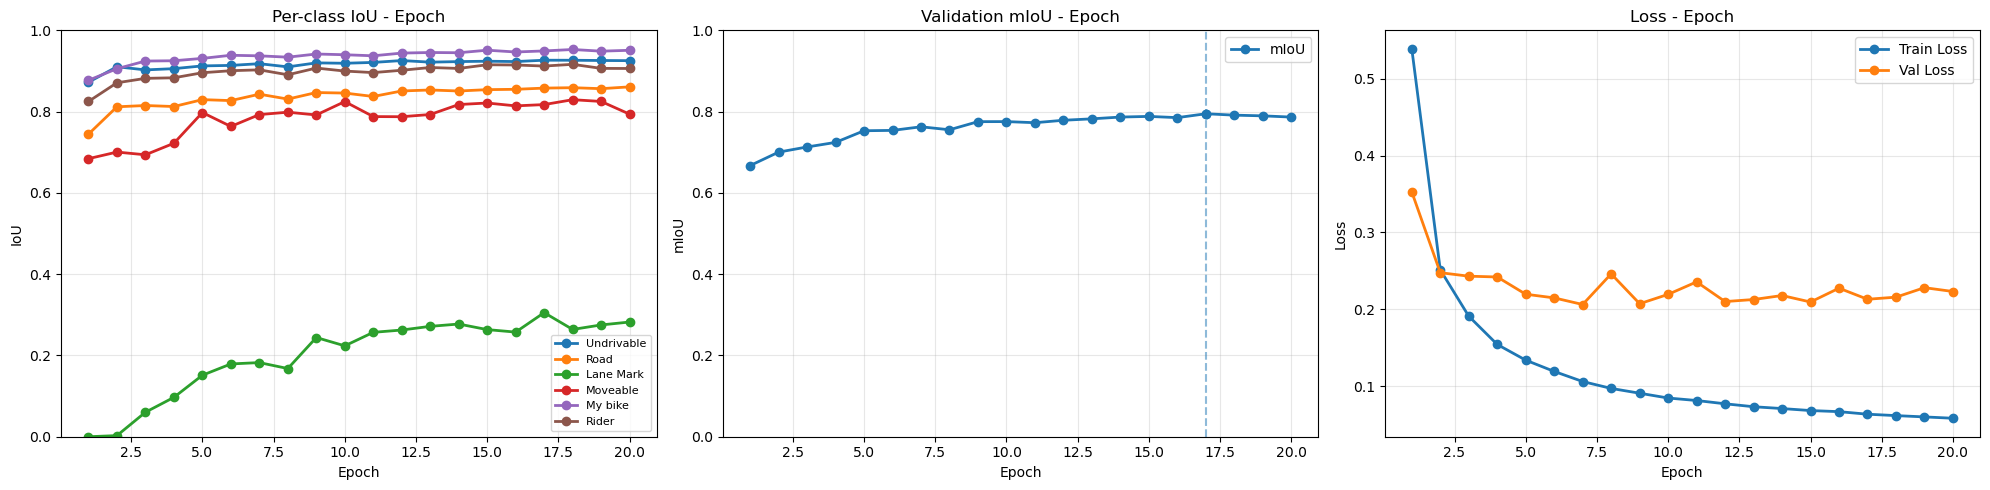

In [24]:
import numpy as np
import matplotlib.pyplot as plt

epochs = history["epoch"]
per_class = np.array(history["per_class_iou"])

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ======================
# ① Per-class IoU
# ======================
ax = axes[0]

for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")
    ax.plot(
        epochs,
        per_class[:, cls],
        marker="o",
        linewidth=2,
        label=name
    )

ax.set_title("Per-class IoU - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("IoU")
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)


# ======================
# ② mIoU
# ======================
ax = axes[1]

ax.plot(
    history["epoch"],
    history["val_miou"],
    marker="o",
    linewidth=2,
    label="mIoU"
)

best_epoch = history["epoch"][np.argmax(history["val_miou"])]
best_miou  = max(history["val_miou"])

ax.axvline(best_epoch, linestyle="--", alpha=0.5)
ax.scatter(best_epoch, best_miou, zorder=5)

ax.set_title("Validation mIoU - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("mIoU")
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()


# ======================
# ③ Loss 그래프
# ======================
ax = axes[2]

ax.plot(
    history["epoch"],
    history["train_loss"],
    marker="o",
    linewidth=2,
    label="Train Loss"
)

ax.plot(
    history["epoch"],
    history["val_loss"],
    marker="o",
    linewidth=2,
    label="Val Loss"
)

ax.set_title("Loss - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True, alpha=0.3)
ax.legend()


plt.tight_layout()
plt.show()

🔥 Worst sample idxs: [5, 17]
idx=5 | pixel_acc=0.8360


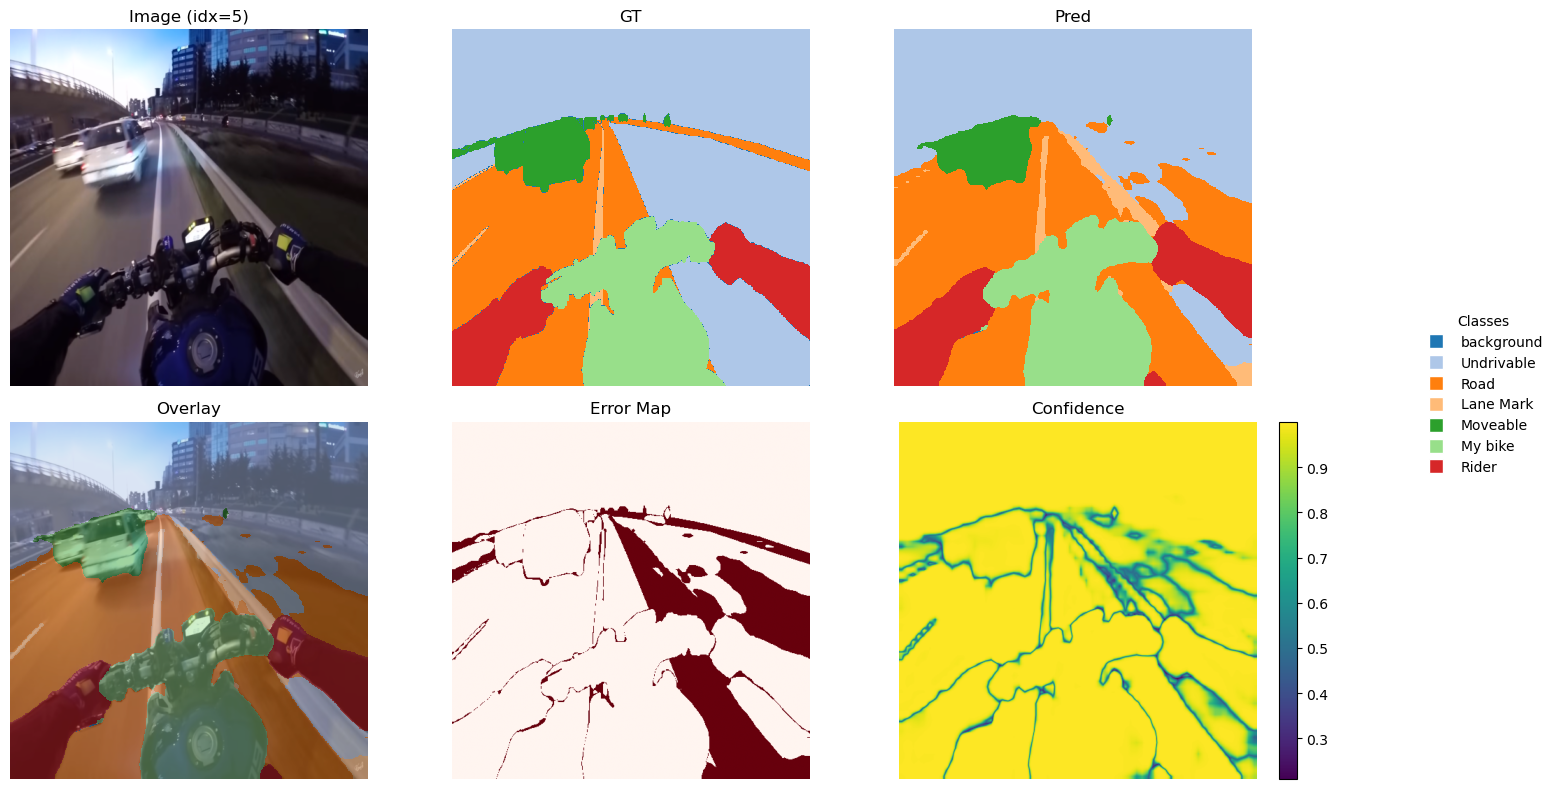

idx=17 | pixel_acc=0.8433


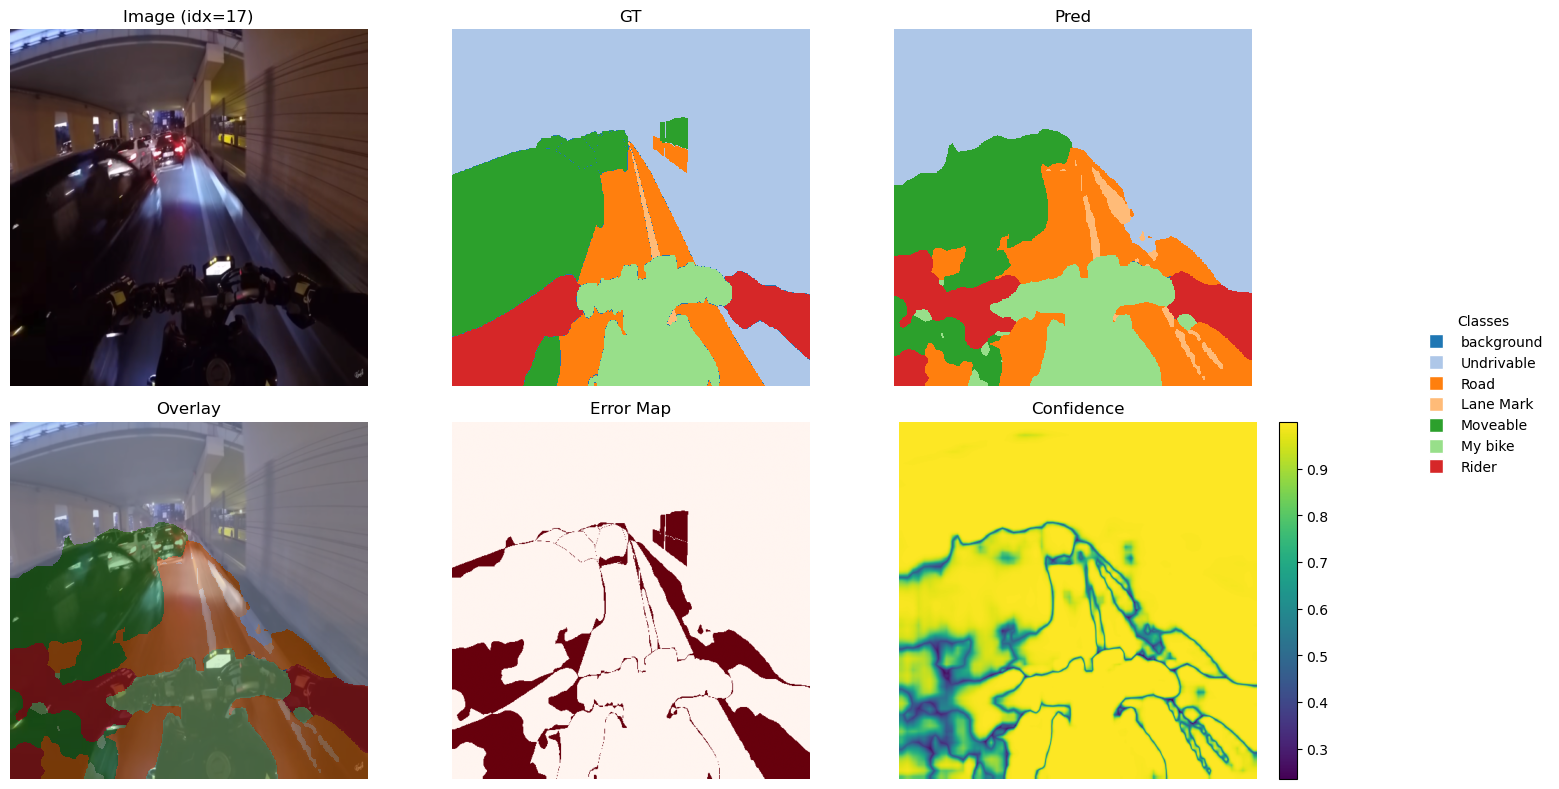

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

# -----------------------------
# 1) logits 추출 (DeepLab(dict) / UNet(tensor) 모두 대응)
# -----------------------------
def get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

# -----------------------------
# 2) 단일 샘플 시각화 (Image / GT / Pred / Overlay / Error / Conf)
# -----------------------------
@torch.no_grad()
def show_pred(model, dataset, idx=0, alpha=0.5):
    model.eval()

    img, mask = dataset[idx]              # img: (3,H,W), mask: (H,W)
    x = img.unsqueeze(0).to(device)

    logits = get_logits(model(x))[0]      # (C,H,W)
    prob = torch.softmax(logits, dim=0)   # (C,H,W)

    pred = prob.argmax(0).cpu().numpy()  # (H,W)
    conf = prob.max(0)[0].cpu().numpy()  # (H,W)
    gt   = mask.cpu().numpy()

    # denorm image
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = (img_np * std + mean).clip(0, 1)

    # colormap
    base_cmap = plt.get_cmap("tab20")
    cmap = ListedColormap(base_cmap.colors[:NUM_CLASSES])

    # error map
    error_map = (pred != gt)

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    axes[0,0].imshow(img_np); axes[0,0].set_title(f"Image (idx={idx})"); axes[0,0].axis("off")
    axes[0,1].imshow(gt,   cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, interpolation="nearest"); axes[0,1].set_title("GT"); axes[0,1].axis("off")
    axes[0,2].imshow(pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, interpolation="nearest"); axes[0,2].set_title("Pred"); axes[0,2].axis("off")

    axes[1,0].imshow(img_np)
    axes[1,0].imshow(pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, alpha=alpha, interpolation="nearest")
    axes[1,0].set_title("Overlay"); axes[1,0].axis("off")

    axes[1,1].imshow(error_map, cmap="Reds")
    axes[1,1].set_title("Error Map"); axes[1,1].axis("off")

    im = axes[1,2].imshow(conf, cmap="viridis")
    axes[1,2].set_title("Confidence"); axes[1,2].axis("off")
    fig.colorbar(im, ax=axes[1,2], fraction=0.046)

    # legend
    handles, labels = [], []
    for cls in range(NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        handles.append(plt.Line2D([0],[0], marker='s', color='w',
                                  markerfacecolor=cmap(cls), markersize=10))
        labels.append(name)

    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.15, 0.5),
               frameon=False, title="Classes")

    plt.tight_layout()
    plt.show()

# -----------------------------
# 3) Worst-k 
# -----------------------------
@torch.no_grad()
def worst_k_visualize(model, dataset, k=2, max_scan=None):
    model.eval()
    scores = []

    N = len(dataset) if max_scan is None else min(len(dataset), max_scan)

    for i in range(N):
        img_t, gt = dataset[i]
        x = img_t.unsqueeze(0).to(device)

        logits = get_logits(model(x))
        pred = logits.argmax(1).squeeze(0).detach().cpu().numpy()
        gt_np = gt.detach().cpu().numpy()

        acc = (pred == gt_np).mean()
        scores.append((acc, i))

    scores.sort(key=lambda x: x[0])  # 낮은 acc 순
    worst_idxs = [i for _, i in scores[:k]]

    print("🔥 Worst sample idxs:", worst_idxs)

    for idx in worst_idxs:
        # 간단 점수 출력(필요 없으면 지워도 됨)
        img_t, gt = dataset[idx]
        x = img_t.unsqueeze(0).to(device)
        logits = get_logits(model(x))
        pred = logits.argmax(1).squeeze(0).detach().cpu().numpy()
        acc = (pred == gt.detach().cpu().numpy()).mean()
        print(f"idx={idx} | pixel_acc={acc:.4f}")

        show_pred(model, dataset, idx=idx, alpha=0.45)

# 실행
worst_k_visualize(model, val_ds, k=2)

### 성능평가(Test dataset)

In [26]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# ======================
# Test Dataset / Loader
# ======================
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,  # ✅ 로컬/주피터에서 안전
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# ======================
# Best Model Load
# ======================
BEST_PATH = "baseline_deeplabv3_resnet50.pth"  # 저장한 파일명
state = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
print("✅ loaded best:", BEST_PATH)

# ======================
# Test Evaluate  (✅ validate 시그니처 맞춤)
# ======================
test_loss, test_miou, test_per_class = validate(
    model, test_loader,
    criterion, device, NUM_CLASSES
)

print("\n===== TEST BENCHMARK =====")
print(f"test_loss = {float(test_loss):.4f}")
print(f"test_mIoU = {float(test_miou):.4f}")

# ----------------------
# per-class IoU 출력 (dict/list 둘 다 대응)
# ----------------------
if isinstance(test_per_class, dict):
    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        v = test_per_class.get(cls, float("nan"))
        if np.isfinite(v):
            print(f"  IoU {name:10s}: {float(v):.4f}")
        else:
            print(f"  IoU {name:10s}: nan")
else:
    arr = np.array(test_per_class, dtype=np.float32)
    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        v = arr[cls] if cls < len(arr) else np.nan
        if np.isfinite(v):
            print(f"  IoU {name:10s}: {float(v):.4f}")
        else:
            print(f"  IoU {name:10s}: nan")


test: 20
✅ loaded best: baseline_deeplabv3_resnet50.pth

===== TEST BENCHMARK =====
test_loss = 0.1628
test_mIoU = 0.8294
  IoU Undrivable: 0.9493
  IoU Road      : 0.8902
  IoU Lane Mark : 0.5174
  IoU Moveable  : 0.7371
  IoU My bike   : 0.9521
  IoU Rider     : 0.9304


### 2.1.2. U-Net(Backbone ResNet 50)

In [27]:
# --- UNet(ResNet encoder) 모델만 교체 ---
import torch.nn as nn

try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("pip install segmentation-models-pytorch 로 설치 후 진행하세요.")

# UNet + ResNet50 encoder (ImageNet pretrained)
core = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None,
)

# smp는 logits만 반환 → torchvision처럼 {"out": logits}로 래핑
class Wrap(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = Wrap(core).to(device)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [28]:
@torch.no_grad()
def compute_iou(pred, target, num_classes):
    # pred/target: (N,H,W)
    ious = []
    per_class = {}
    for cls in range(num_classes):
        pred_i = (pred == cls)
        targ_i = (target == cls)
        inter = (pred_i & targ_i).sum().item()
        union = (pred_i | targ_i).sum().item()
        if union == 0:
            iou = float("nan")
        else:
            iou = inter / union
        per_class[cls] = iou
        ious.append(iou)
    # mean over valid classes
    valid = [x for x in ious if not (isinstance(x, float) and np.isnan(x))]
    miou = float(np.mean(valid)) if len(valid) else 0.0
    return miou, per_class

In [29]:
import torch
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes, ignore_index=None):
    model.eval()
    total_loss = 0.0

    # confusion matrix: [num_classes, num_classes]
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)

    for imgs, masks in tqdm(loader, desc="val", leave=False):
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = model(imgs)["out"]              # (N,C,H,W)
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)             # (N,H,W)

        # flatten
        preds = preds.view(-1).detach().cpu()
        gts   = masks.view(-1).detach().cpu()

        if ignore_index is not None:
            keep = (gts != ignore_index)
            preds = preds[keep]
            gts   = gts[keep]

        k = (gts >= 0) & (gts < num_classes)
        inds = num_classes * gts[k] + preds[k]
        conf += torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)

    # IoU 계산
    tp = conf.diag().float()
    fp = conf.sum(0).float() - tp
    fn = conf.sum(1).float() - tp
    denom = tp + fp + fn

    per_class_iou = (tp / torch.clamp(denom, min=1.0)).numpy()  # shape: [C]
    # background(0) 제외 mIoU (원하면 포함/제외 변경 가능)
    miou = float(np.nanmean(per_class_iou[1:]))

    # dict 형태로도 반환(기존 코드 호환)
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}

    val_loss = total_loss / len(loader.dataset)
    return val_loss, miou, per_class_dict

In [30]:
# =========================================================
# UNet(ResNet50 encoder) + 학습 루프 (인자형 train/validate 대응)
# =========================================================

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# =========================
# 0) UNet 모델 정의 (ResNet50 encoder)
# =========================
try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("segmentation_models_pytorch 필요: pip install segmentation-models-pytorch")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

core_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    """smp는 Tensor(logits) 반환 → torchvision처럼 {'out': logits}로 맞춤"""
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = WrapOut(core_unet).to(device)

# =========================
# 1) Loss / Optimizer 재생성 (필수)
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# sanity check
model_param_ids = set(id(p) for p in model.parameters())
opt_param_ids = set(id(p) for g in optimizer.param_groups for p in g["params"])
assert len(model_param_ids & opt_param_ids) > 0, "❌ optimizer가 UNet 파라미터를 안 잡고 있습니다."

print("✅ UNet ready:", type(model))
print("✅ optimizer param count:", sum(len(g["params"]) for g in optimizer.param_groups))

# =========================
# 2) CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3
MODEL_NAME = "baseline_unet_resnet50.pth"
HISTORY_NAME = "history_unet_resnet50.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# 3) per_class 정리 유틸
# =========================
def to_per_class_list(per_class, num_classes: int):
    out = [np.nan] * num_classes
    if isinstance(per_class, dict):
        for c in range(num_classes):
            if c in per_class:
                try:
                    v = float(per_class[c])
                    out[c] = v if np.isfinite(v) else np.nan
                except:
                    out[c] = np.nan
        return out
    if isinstance(per_class, (list, tuple, np.ndarray)):
        L = min(len(per_class), num_classes)
        for c in range(L):
            try:
                v = float(per_class[c])
                out[c] = v if np.isfinite(v) else np.nan
            except:
                out[c] = np.nan
        return out
    return out

# =========================
# 4) history
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# 5) TRAIN LOOP  (✅ 인자형 함수 호출로 수정)
# =========================
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    va_loss, va_miou, per_class = validate(model, val_loader, criterion, device, NUM_CLASSES)

    per_class_list = to_per_class_list(per_class, NUM_CLASSES)

    print(f"[UNet] [{epoch:02d}/{EPOCHS}] "
          f"train_loss={float(tr_loss):.4f} | val_loss={float(va_loss):.4f} | mIoU={float(va_miou):.4f}")

    for cls in range(1, NUM_CLASSES):
        cls_name = train2name.get(cls, str(cls)) if isinstance(train2name, dict) else str(cls)
        iou = per_class_list[cls]
        print(f"  IoU {cls_name:10s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

    history["epoch"].append(int(epoch))
    history["train_loss"].append(float(tr_loss))
    history["val_loss"].append(float(va_loss))
    history["val_miou"].append(float(va_miou))
    history["per_class_iou"].append([float(x) if np.isfinite(x) else np.nan for x in per_class_list])

    # best + early stopping
    if float(va_miou) > float(best_miou):
        best_miou = float(va_miou)
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved: {MODEL_NAME} (best_mIoU={best_miou:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE}) | best_mIoU={best_miou:.4f}")

    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}")
        print(f"Best mIoU: {best_miou:.4f}")
        break

# =========================
# 6) history 저장
# =========================
try:
    np.savez(
        HISTORY_NAME,
        epoch=np.array(history["epoch"], dtype=np.int32),
        train_loss=np.array(history["train_loss"], dtype=np.float32),
        val_loss=np.array(history["val_loss"], dtype=np.float32),
        val_miou=np.array(history["val_miou"], dtype=np.float32),
        per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
    )
    print(f"\n✅ history saved: {HISTORY_NAME}")
except Exception as e:
    print(f"\n⚠ history save skipped: {e}")

device: cuda
✅ UNet ready: <class '__main__.WrapOut'>
✅ optimizer param count: 191


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [01/30] train_loss=0.9548 | val_loss=0.6589 | mIoU=0.5754
  IoU Undrivable: 0.8390
  IoU Road      : 0.7018
  IoU Lane Mark : 0.0004
  IoU Moveable  : 0.4734
  IoU My bike   : 0.7818
  IoU Rider     : 0.6563
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.5754)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [02/30] train_loss=0.4634 | val_loss=0.4553 | mIoU=0.6196
  IoU Undrivable: 0.8428
  IoU Road      : 0.7664
  IoU Lane Mark : 0.0001
  IoU Moveable  : 0.5183
  IoU My bike   : 0.8347
  IoU Rider     : 0.7552
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6196)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [03/30] train_loss=0.3352 | val_loss=0.3836 | mIoU=0.6553
  IoU Undrivable: 0.8587
  IoU Road      : 0.7739
  IoU Lane Mark : 0.0001
  IoU Moveable  : 0.5719
  IoU My bike   : 0.8868
  IoU Rider     : 0.8402
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6553)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [04/30] train_loss=0.2841 | val_loss=0.3468 | mIoU=0.6607
  IoU Undrivable: 0.8770
  IoU Road      : 0.7978
  IoU Lane Mark : 0.0001
  IoU Moveable  : 0.5531
  IoU My bike   : 0.8787
  IoU Rider     : 0.8575
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6607)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [05/30] train_loss=0.2694 | val_loss=0.5066 | mIoU=0.5657
  IoU Undrivable: 0.8698
  IoU Road      : 0.7380
  IoU Lane Mark : 0.0006
  IoU Moveable  : 0.4251
  IoU My bike   : 0.8493
  IoU Rider     : 0.5113
  ⏸ no improvement (1/3) | best_mIoU=0.6607


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [06/30] train_loss=0.2441 | val_loss=0.3368 | mIoU=0.6808
  IoU Undrivable: 0.8611
  IoU Road      : 0.8089
  IoU Lane Mark : 0.0372
  IoU Moveable  : 0.6337
  IoU My bike   : 0.8918
  IoU Rider     : 0.8524
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6808)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [07/30] train_loss=0.2117 | val_loss=0.3473 | mIoU=0.6683
  IoU Undrivable: 0.8639
  IoU Road      : 0.7890
  IoU Lane Mark : 0.0294
  IoU Moveable  : 0.5932
  IoU My bike   : 0.8809
  IoU Rider     : 0.8535
  ⏸ no improvement (1/3) | best_mIoU=0.6808


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [08/30] train_loss=0.2019 | val_loss=0.2854 | mIoU=0.7350
  IoU Undrivable: 0.8875
  IoU Road      : 0.8175
  IoU Lane Mark : 0.2163
  IoU Moveable  : 0.7059
  IoU My bike   : 0.9220
  IoU Rider     : 0.8611
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7350)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [09/30] train_loss=0.1948 | val_loss=0.3043 | mIoU=0.7021
  IoU Undrivable: 0.8933
  IoU Road      : 0.7880
  IoU Lane Mark : 0.1160
  IoU Moveable  : 0.6937
  IoU My bike   : 0.9057
  IoU Rider     : 0.8159
  ⏸ no improvement (1/3) | best_mIoU=0.7350


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [10/30] train_loss=0.1956 | val_loss=0.2586 | mIoU=0.7559
  IoU Undrivable: 0.8950
  IoU Road      : 0.8424
  IoU Lane Mark : 0.2849
  IoU Moveable  : 0.7162
  IoU My bike   : 0.9275
  IoU Rider     : 0.8692
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7559)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [11/30] train_loss=0.1849 | val_loss=0.2945 | mIoU=0.7437
  IoU Undrivable: 0.8845
  IoU Road      : 0.8273
  IoU Lane Mark : 0.2543
  IoU Moveable  : 0.6833
  IoU My bike   : 0.9289
  IoU Rider     : 0.8842
  ⏸ no improvement (1/3) | best_mIoU=0.7559


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [12/30] train_loss=0.1734 | val_loss=0.2990 | mIoU=0.7362
  IoU Undrivable: 0.8731
  IoU Road      : 0.8030
  IoU Lane Mark : 0.2711
  IoU Moveable  : 0.7056
  IoU My bike   : 0.9155
  IoU Rider     : 0.8489
  ⏸ no improvement (2/3) | best_mIoU=0.7559


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [13/30] train_loss=0.1597 | val_loss=0.2805 | mIoU=0.7446
  IoU Undrivable: 0.8752
  IoU Road      : 0.8171
  IoU Lane Mark : 0.2871
  IoU Moveable  : 0.6704
  IoU My bike   : 0.9255
  IoU Rider     : 0.8921
  ⏸ no improvement (3/3) | best_mIoU=0.7559

🛑 Early stopping triggered at epoch 13
Best mIoU: 0.7559

✅ history saved: history_unet_resnet50.npz


### U-Net Test

In [31]:
# =========================================================
# UNet TEST BENCHMARK  ✅복붙용 수정본 (NUM_WORKERS=0 기준)
# =========================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ======================
# 0) device
# ======================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ======================
# 1) Test Dataset / Loader
# ======================
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

# ✅ NUM_WORKERS=0이면 아래 옵션들( worker_init_fn / generator / persistent_workers ) 제거
test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# ======================
# 2) UNet 모델 재구성 + 로드
# ======================
try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("segmentation_models_pytorch 필요: pip install segmentation-models-pytorch")

core_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    """smp는 Tensor(logits) 반환 → torchvision처럼 {'out': logits}로 맞춤"""
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = WrapOut(core_unet).to(device)

# ======================
# 3) Loss (validate에서 필요)
# ======================
criterion = nn.CrossEntropyLoss()

# ======================
# 4) best weight 로드
# ======================
BEST_PATH = "baseline_unet_resnet50.pth"   # ✅ UNet best 파일
state = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("✅ loaded best:", BEST_PATH)

# ======================
# 5) TEST 실행 (인자형 validate 호출)
# ======================
test_loss, test_miou, test_per_class = validate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=NUM_CLASSES,
    ignore_index=None
)

print("\n===== UNet TEST BENCHMARK =====")
print(f"test_loss = {float(test_loss):.4f}")
print(f"test_mIoU = {float(test_miou):.4f}")

# test_per_class는 dict 형태(권장) / list 형태 둘 다 대응
for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")

    if isinstance(test_per_class, dict):
        v = float(test_per_class.get(cls, np.nan))
    else:
        v = float(test_per_class[cls]) if cls < len(test_per_class) else np.nan

    print(f"  IoU {name:10s}: {'nan' if np.isnan(v) else f'{v:.4f}'}")


device: cuda
test: 20
✅ loaded best: baseline_unet_resnet50.pth


val:   0%|          | 0/5 [00:00<?, ?it/s]


===== UNet TEST BENCHMARK =====
test_loss = 0.2052
test_mIoU = 0.7800
  IoU Undrivable: 0.9248
  IoU Road      : 0.8647
  IoU Lane Mark : 0.4239
  IoU Moveable  : 0.6145
  IoU My bike   : 0.9432
  IoU Rider     : 0.9090


### Baseline 결정
#### 1) Test 결과 비교(총 3회 시행)
---
- 총 3회 반복하여 테스트한 결과 3회 모두 Deeplab v3 U-Net 보다 우수함
- 특히 가장 좋은 성능간 비교를 기준으로 양자의 차이를 비교하면 아래와 같음

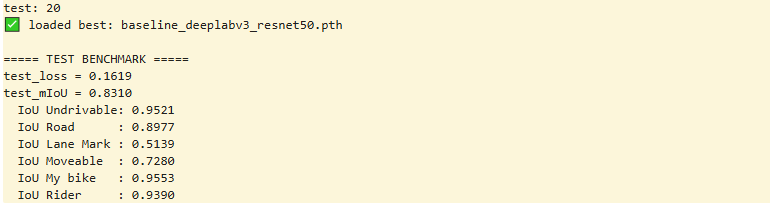
##### mIoU
- UNet: 0.7988
- DeepLabV3: 0.8310 
- → DeepLabV3 +0.0322p( 우세)
  
#### test_loss
- UNet: 0.1693
- DeepLabV3: 0.1619 → DeepLab이 더 낮음(좋음)

##### Lane Mark IoU 
- DeepLab: 0.5139
- UNet: 0.4196
- → +0.0943 Deeplab 우세

#### 클래스별 IoU 비교 (DeepLab이 전부 우세)
- Undrivable: 0.9397 → 0.9521 (+0.0124)
- Road: 0.8834 → 0.8977 (+0.0143)
- Lane Mark: 0.4196 → 0.5139 (+0.0943) 
- Moveable: 0.6696 → 0.7280 (+0.0584)
- My bike: 0.9525 → 0.9553 (+0.0028)
- Rider: 0.9279 → 0.9390 (+0.0111)

### 2) 베이스라인 결정
- 2. Base Line 모델 결정: DeepLabV3-ResNet50 확정

### 2.2.1 DeepLab V3 (Backbone EffientNet-B3)

In [32]:
# =========================================================
# DeepLabV3 (EfficientNet-B3 encoder) - model 생성 
# - 존 train_one_epoch / validate / 시각화 / test 코드 그대로 재사용
# - 핵심: smp 모델(Tensor logits)을 torchvision처럼 {"out": logits}로 래핑
# =========================================================

import torch
import torch.nn as nn

import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ---- DeepLabV3 with EfficientNet-B3 encoder ----
core = smp.DeepLabV3(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}  # torchvision 호환

model = WrapOut(core).to(device)
print("✅ model ready:", type(model))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# sanity check
model_param_ids = set(id(p) for p in model.parameters())
opt_param_ids = set(id(p) for g in optimizer.param_groups for p in g["params"])
assert len(model_param_ids & opt_param_ids) > 0, "❌ optimizer가 현재 model 파라미터를 안 잡고 있습니다."

print("✅ optimizer ok")


device: cuda


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

✅ model ready: <class '__main__.WrapOut'>
✅ optimizer ok


In [35]:
import numpy as np
import torch

# ---------------------------------
# 1) 모델 출력(logits) 통일
#   - torchvision: dict["out"]
#   - smp: Tensor
# ---------------------------------
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

# ---------------------------------
# 2) confusion matrix 누적
# ---------------------------------
def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background: bool = True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn

    iou = tp / torch.clamp(denom, min=1.0)  # (C,)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

# ---------------------------------
# 3) train / validate (✅ exclude_background 지원)
# ---------------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))        # (N,C,H,W)
        loss = criterion(logits, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background: bool = True, ignore_index=None):
    model.eval()
    total_loss = 0.0

    # CPU 누적
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))        # (N,C,H,W)
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)              # (N,H,W)
        conf += _confusion_from_pred(
            pred.detach().cpu(),
            masks.detach().cpu(),
            num_classes=num_classes,
            ignore_index=ignore_index
        )

    val_loss = total_loss / len(loader.dataset)
    miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)

    # 기존 코드 호환: dict로 반환
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}
    return val_loss, miou, per_class_dict

va_loss, va_miou, per_class = validate(
    model, val_loader, criterion, device, NUM_CLASSES,
    exclude_background=True
)


In [36]:
import os
import numpy as np
import torch

# =========================
# CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3

MODEL_NAME = "deeplabv3_effb3_best.pth"
HISTORY_NAME = "deeplabv3_effb3_history.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# history buffer
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# TRAIN LOOP
# =========================
for epoch in range(1, EPOCHS + 1):

    # ----- train -----
    tr_loss = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )

    # ----- validate -----
    va_loss, va_miou, per_class = validate(
        model,
        val_loader,
        criterion,
        device,
        NUM_CLASSES,
        exclude_background=True
    )

    # ---- 출력 ----
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={va_miou:.4f}")

    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        print(f"  IoU {name:10s}: {per_class[cls]:.4f}")

    # ---- history 저장 ----
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["per_class_iou"].append(
        [per_class[c] for c in range(NUM_CLASSES)]
    )

    # ---- best model ----
    if va_miou > best_miou:
        best_miou = va_miou
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved best model ({best_miou:.4f})")

    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print("🛑 Early stopping triggered")
        break

# =========================
# history 저장
# =========================
np.savez(
    HISTORY_NAME,
    epoch=np.array(history["epoch"]),
    train_loss=np.array(history["train_loss"]),
    val_loss=np.array(history["val_loss"]),
    val_miou=np.array(history["val_miou"]),
    per_class_iou=np.array(history["per_class_iou"])
)

print("✅ history saved")


[01/30] train_loss=0.3455 | val_loss=0.3495 | mIoU=0.6425
  IoU Undrivable: 0.8763
  IoU Road      : 0.7187
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6401
  IoU My bike   : 0.8255
  IoU Rider     : 0.7946
  ✅ saved best model (0.6425)
[02/30] train_loss=0.2790 | val_loss=0.3118 | mIoU=0.6678
  IoU Undrivable: 0.8845
  IoU Road      : 0.7436
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6878
  IoU My bike   : 0.8541
  IoU Rider     : 0.8367
  ✅ saved best model (0.6678)
[03/30] train_loss=0.2391 | val_loss=0.2829 | mIoU=0.6853
  IoU Undrivable: 0.8892
  IoU Road      : 0.7705
  IoU Lane Mark : 0.0181
  IoU Moveable  : 0.6949
  IoU My bike   : 0.8870
  IoU Rider     : 0.8521
  ✅ saved best model (0.6853)
[04/30] train_loss=0.2045 | val_loss=0.2555 | mIoU=0.6975
  IoU Undrivable: 0.8948
  IoU Road      : 0.7836
  IoU Lane Mark : 0.0077
  IoU Moveable  : 0.7379
  IoU My bike   : 0.9034
  IoU Rider     : 0.8577
  ✅ saved best model (0.6975)
[05/30] train_loss=0.1901 | val_loss=0.2505 | mI

In [39]:
# =========================================================
# ✅ DeepLabV3(EfficientNet-B3) TEST BENCHMARK - 복붙용 (자동 로드 호환)
# - MODEL_NAME: deeplabv3_effb3_best.pth
# - 학습 때 WrapOut(core)로 저장했든, core로 저장했든 둘 다 로드되게 처리
# - NUM_WORKERS=2기준
# =========================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import OrderedDict

import segmentation_models_pytorch as smp

# -------------------------
# CONFIG
# -------------------------
MODEL_NAME   = "deeplabv3_effb3_best.pth"
HISTORY_NAME = "deeplabv3_effb3_history.npz"  # 테스트엔 필수 아님

# -------------------------
# device
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -------------------------
# Test Dataset / Loader
# -------------------------
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# -------------------------
# WrapOut (학습 때 썼던 래퍼)
# -------------------------
class WrapOut(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

# -------------------------
# logits 공용
# -------------------------
def _get_logits(model_out):
    return model_out["out"] if isinstance(model_out, dict) else model_out

# -------------------------
# confusion / IoU 유틸
# -------------------------
def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)
        conf += _confusion_from_pred(
            pred.detach().cpu(),
            masks.detach().cpu(),
            num_classes=num_classes,
            ignore_index=ignore_index
        )

    test_loss = total_loss / len(loader.dataset)
    miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}
    return float(test_loss), float(miou), per_class_dict

# -------------------------
# 모델 생성 (core + wrapped 둘 다 준비)
# -------------------------
core = smp.DeepLabV3(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
).to(device)

wrapped = WrapOut(core).to(device)

criterion = nn.CrossEntropyLoss()

# -------------------------
# state_dict 로드 (자동 호환: m. prefix 있으면 wrapped에, 없으면 core에)
# -------------------------
state = torch.load(MODEL_NAME, map_location=device)

# 1) key에 "m."가 있으면 -> WrapOut 저장본
has_m_prefix = any(k.startswith("m.") for k in state.keys())

if has_m_prefix:
    model = wrapped
    model.load_state_dict(state, strict=True)
    print("✅ loaded as WrapOut(model). state_dict keys include 'm.'")
else:
    model = core
    model.load_state_dict(state, strict=True)
    print("✅ loaded as core(model). state_dict keys without 'm.'")

model.eval()
print("✅ loaded best:", MODEL_NAME)

# -------------------------
# TEST 실행
# -------------------------
test_loss, test_miou, test_per_class = validate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=NUM_CLASSES,
    exclude_background=True,
    ignore_index=None
)

print("\n===== DeepLabV3-EffB3 TEST BENCHMARK =====")
print(f"test_loss = {test_loss:.4f}")
print(f"test_mIoU = {test_miou:.4f}")

for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")
    v = float(test_per_class.get(cls, np.nan))
    print(f"  IoU {name:10s}: {'nan' if np.isnan(v) else f'{v:.4f}'}")


device: cuda
test: 20
✅ loaded as WrapOut(model). state_dict keys include 'm.'
✅ loaded best: deeplabv3_effb3_best.pth

===== DeepLabV3-EffB3 TEST BENCHMARK =====
test_loss = 0.1558
test_mIoU = 0.8072
  IoU Undrivable: 0.9467
  IoU Road      : 0.8840
  IoU Lane Mark : 0.4354
  IoU Moveable  : 0.7160
  IoU My bike   : 0.9428
  IoU Rider     : 0.9183


### Baseline 결정
---
#### Test 결과 비교
##### mIoU
- EfficientNet-B3: 0.8028
- ResNet50: 0.8294 → +0.0266p (약 +2.7%p)
#### 클래스별 IoU(핵심 차이)
- Undrivable: 0.9445 vs 0.9493 (ResNet +0.0048)
- Road: 0.8770 vs 0.8902 (ResNet +0.0132)
- Lane Mark: 0.4232 vs 0.5174 (ResNet +0.0942) ✅ 가장 중요한 차이
- Moveable: 0.7177 vs 0.7371 (ResNet +0.0194)
- My bike: 0.9380 vs 0.9521 (ResNet +0.0141)
- Rider: 0.9162 vs 0.9304 (ResNet +0.0142)
- 결론: EffientNet이 test loss가 낮음 그러나 IoU 분야는 ResNet50이 모든 클래스에서 더 좋고, 특히 Lane Mark에서 큰 차이(+0.094)
#### 최종 baseline 결정: Deeplab v3 (backbone: ResNet 50)

## 3. 피처엔지니어링 

### 1. 피처엔지니어링 목표(방향)


### 1순위: Gamma + Crop(하단 중심)
- 저조도에서 선이 안 보이는 문제를 직접 건드림(Gamma)
- Lane이 실제로 많이 있는 영역(하단)을 더 크게 보게 만듦(Crop)
- RandomGamma(0.5~2.0) (어두운 쪽 강화 비중 ↑)
-Bottom-center crop 또는 Random crop with lane-presence
- 원본(또는 768) → 하단 60~70% 영역 중심으로 512 crop → resize 유지

### 2순위: CLAHE(약하게) + Crop(하단 중심)

- 야간에서 국부 대비를 살려 “선”을 띄우는 데 강함. 단, 과하면 노이즈도 키우므로 “약하게”가 중요
- CLAHE(clipLimit=2~3, tileGrid=8x8) (RGB 전체 or L 채널만)
- Bottom-center crop / lane-aware crop

### 3순위: Gamma + Contrast/ColorJitter
- 저조도 분포를 넓게 커버하면서(감마)
- 대비를 흔들어 라인을 다양한 조건에서 보게 함(contrast)
- RandomGamma(0.5~2.0)
- ColorJitter(contrast 중심, brightness는 약하게)
- contrast 0.6~1.6, brightness 0.8~1.2

### 4순위: CLAHE(약하게) + Gamma
- CLAHE로 “국부 대비”를 올리고
- Gamma로 “전체 밝기 분포”를 흔들어 저조도 적응 강화. 단, 둘 다 강하면 과보정/노이즈 증폭 위험
- CLAHE 약하게 → Gamma 약~중. 팁: 확률로 켜기(예: CLAHE 0.3, Gamma 0.7)
- 
### 5순위: Gamma + Noise(ISO 흉내)
- 어두운 환경의 핵심 난제는 “노이즈+저대비”라서
- Lane이 노이즈에 묻혀도 버티게 만들 수 있음
- RandomGamma(0.5~2.0)
- Gaussian/Poisson noise (약~중)

### Gamma + Motion/Defocus Blur
- 야간 주행에서 Lane은 흔들림/블러에 잘 죽음. 다만 너무 강하면 학습이 어려워져서 우선순위는 낮춤
- RandomGamma
- MotionBlur(약) 또는 DefocusBlur(약)

In [ ]:
### 2. 진행